In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import os
print(os.listdir("../input"))  # input内のファイル表示
import warnings
warnings.filterwarnings("ignore")  # 原因不明の実行エラーが出たら邪魔だから表示させない

# rcParamsは辞書だけど、これを書き換えれば全体の設定が変わるよ
plt.rcParams['figure.figsize'] = (16, 9)
sns.set_palette('gist_earth')  # snsで使うカラーパレット指定


['.DS_Store', 'gender_submission.csv', 'test.csv', 'train.csv']


In [3]:
# read datasets
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
# Merge 2 dataset for EDA and feature Engineering
# Explanatory Data Analysis（略してEDA）とは、データの特徴を探求し、
# 構造を理解することを目的としたデータサイエンスの最初の一歩
df_train.head(10)
df_train.head(10)
full = pd.concat([df_train, df_test], axis=0, sort=True)
full.head(10)
# set passengerId as index
full.set_index('PassengerId', drop=False, inplace=True)
train = full[:891]
# inplaceは元の配列を変更するかどうか、dropはindex列を捨てるかどうか
full.head(10)
print("Dataset containns {} records, with {} variables.".format(full.shape[0], full.shape[1]))

Dataset containns 1309 records, with 12 variables.


In [4]:
print(max(full.Fare))
print(max(df_train.Fare))
print(max(df_test.Fare))

512.3292
512.3292
512.3292


In [5]:
# idenfity missing values
nan = full.isnull() # dataframeの中で、
# nuneかどうかそれぞれのデータについて判定、TorFを格納
nan.head(10)
type(nan)

pandas.core.frame.DataFrame

In [6]:
# idenfity missing values
nan = full.isnull().sum()  # sum()はDataframeに対しては列ごとに合計を計算 
nan.head(10)

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
dtype: int64

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Survived'], dtype='object')


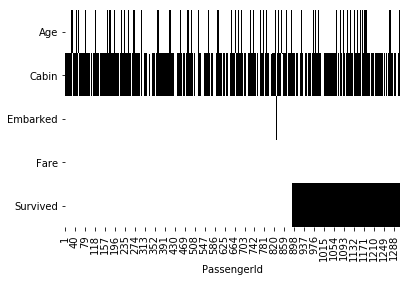

In [7]:
nan = full.isnull().sum()
idx_nan = nan.mask(nan==0).dropna().index  
print(idx_nan)
# mask()は　条件に合わないところは、オリジナルの値を維持。
# dropnaで0もしくはNaNを除く.indexでindexのみのリスト作成
# cbar:カラーバーをどこに置くか。今回なし
# cmapはカラーマップか。binaryだと2色なんだろな
sns.heatmap(full[idx_nan].transpose().isnull(), cmap='binary', cbar=False)
# 欠損値を持つデータについて、
# transpose()転置

In [8]:
print(max(full.Fare))
print(max(df_train.Fare))
print(max(df_test.Fare))

512.3292
512.3292
512.3292


In [9]:
nan[idx_nan].drop('Survived').sort_values() # 整列。survived落とす

Fare           1
Embarked       2
Age          263
Cabin       1014
dtype: int64

In [10]:
# data cleaning
# ticket and cabin gives us information about where passengers is
# 先ずはチケットから
np.sort(full['Ticket'].unique())  # uniqueは要素の重複をなくしたものを返す

array(['110152', '110413', '110465', '110469', '110489', '110564',
       '110813', '111163', '111240', '111320', '111361', '111369',
       '111426', '111427', '111428', '112050', '112051', '112052',
       '112053', '112058', '112059', '112277', '112377', '112378',
       '112379', '112901', '113028', '113038', '113043', '113044',
       '113050', '113051', '113054', '113055', '113056', '113059',
       '113501', '113503', '113505', '113509', '113510', '113514',
       '113572', '113760', '113767', '113773', '113776', '113778',
       '113780', '113781', '113783', '113784', '113786', '113787',
       '113788', '113789', '113790', '113791', '113792', '113794',
       '113795', '113796', '113798', '113800', '113801', '113803',
       '113804', '113806', '113807', '11668', '11751', '11752', '11753',
       '11755', '11765', '11767', '11769', '11770', '11771', '11774',
       '11778', '11813', '11967', '1222', '12233', '12460', '12749',
       '13049', '13050', '13213', '13214', '13236',

In [11]:
def parse_ticket(str1):
    '''
    function to parse the letter part of the ticket code
    '''
    # \dは数字\d{4,7}で4から7桁の数字
    # |はor
    m = re.search(r'(.*)(\s\d|\s\d{4,7}$)', str1)
    # .は改行以外の任意の１文字
    # \s=スペース、$は末尾にマッチ
    s = re.search(r'[A-Z]+', str1)  # TorFが格納。マッチなので。
    # print(s)
    if m:
        str2 = m.group(1)  # マッチした部分の1番目
        # print("{}\t{}\t{}\t{}".format(str1, m.group(0), 
        #                          m.group(1), m.group(2)))
        # ()で中身キャプチャ、[A-Z]でA-Zの文字、+でその1個以上の連続
        # *だと0個以上の連続
        # ^先頭にマッチ
        # マッチとキャプチャは違うよ
        n = re.search(r'([A-Z]+)[^A-Z0-9]*([A-Z]+)*[^A-Z0-9]* \
                      ([A-Z0-9]*)[^A-Z]*([A-Z]*)*', str2)
        new_str = ''
        if n:
            if n.group(1):
                new_str+=n.group(1)
                if n.group(2) or n.group(3):
                    if n.group(3):
                        new_str+=n.group(3)
                        if n.group(4):
                            new_str+=n.group(4)
                            if n.group(5):
                                new_str+=n.group(5)
    elif s:
        new_str = s.group(0)  # Ticket with letters only
        # group(0)はキャプチャしたもの全部
    else:
        new_str = 'XXX'  # Ticket with only numerical values
    return new_str

# .特定のカラム名でも抽出できるんだってさ。へー
full['Ticket_short'] = full.Ticket.map(parse_ticket)
        

In [12]:
full.head(100)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Ticket_short
PassengerId,,,,,,,,,,,,,
1,22.00,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,
2,38.00,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,
3,26.00,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,
4,35.00,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,XXX
5,35.00,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,XXX
6,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877,XXX
7,54.00,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,XXX
8,2.00,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,XXX
9,27.00,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742,XXX


In [13]:
print(max(full.Fare))
print(max(df_train.Fare))
print(max(df_test.Fare))

512.3292
512.3292
512.3292


In [14]:
df_train.head(30)
        

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [15]:
def parse_Cabin(cabin):
    if type(cabin) == str:
        m = re.search(r'([A-Z])+', cabin)
        # print(m.group(0) == m.group(1))
        return m.group(1)
    else:
        return 'X'
full["Cabin_short"] = full.Cabin.map(parse_Cabin)

In [16]:
print(max(full.Fare))
print(max(df_train.Fare))
print(max(df_test.Fare))

512.3292
512.3292
512.3292


Text(0.5,0,'Fare(Adjusted)')

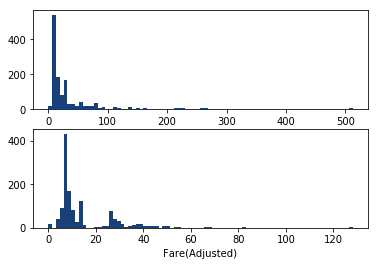

In [17]:
# Fare Adjustment, Fare/# of person
fare_origin = full["Fare"].copy()  # pandasのコピーはデフォでdeep
# print('-'*33)
# print(full.groupby('Ticket')  # group byは値ごとにグループ分け
# グループ分けの結果は出力できないんだってさ
# print('-'*33)
# print(full.groupby('Ticket').Fare.head(10))
# print('-'*33)
# print(full.groupby('Ticket').Fare.count())  
# グループごとに"Fare"の値の種類についてカウント
dict_ticket_size = dict(full.groupby('Ticket').Fare.count())
ticket_size = full["Ticket"].map(dict_ticket_size)
# Ticketの枚数ごとの数、リスト作成
full["Fare"] = full.Fare/ ticket_size

# Plot Fare Adjusted
fit, (ax0, ax1) = plt.subplots(2)
ax0.hist(fare_origin.dropna(), bins=80)
ax0.set_xlabel('Fare(Original)')

ax1.hist(full["Fare"].dropna(), bins=80)
ax1.set_xlabel('Fare(Adjusted)')


In [18]:
# Calculate mean fare cost for each PClass
dict_fare_by_Pclass = dict(full.groupby('Pclass').Fare.mean())
# それぞれのPclassグループに対してFareの平均を対応させる
# fill value according to Pclass
# locはpandas-dataの見たい場所を行と列で指定できる
# mapはリストの各要素に演算を適用してくれるという理解で良さそう
# .mapにしたら.の前が引数になるんだろうなあ
# FareがNullのデータに関して、Pclassを取り出す。
missing_fare = full.loc[full.Fare.isnull(), 'Pclass'].map(dict_fare_by_Pclass)
# fill value according to Pclass
full.loc[full.Fare.isnull(), 'Pclass'] = missing_fare

In [19]:
# Descriptive Statistics
print(full.describe())
# :.2fで小数点以下の桁数指定
print("survived: {:.2f}%".format(full.Survived.mean()*100))

               Age         Fare        Parch  PassengerId       Pclass  \
count  1046.000000  1308.000000  1309.000000  1309.000000  1309.000000   
mean     29.881138    14.757627     0.385027   655.000000     2.298189   
std      14.413493    13.555638     0.865560   378.020061     0.849090   
min       0.170000     0.000000     0.000000     1.000000     1.000000   
25%      21.000000     7.550000     0.000000   328.000000     2.000000   
50%      28.000000     8.050000     0.000000   655.000000     3.000000   
75%      39.000000    15.008325     0.000000   982.000000     3.000000   
max      80.000000   128.082300     9.000000  1309.000000     7.329146   

             SibSp    Survived  
count  1309.000000  891.000000  
mean      0.498854    0.383838  
std       1.041658    0.486592  
min       0.000000    0.000000  
25%       0.000000    0.000000  
50%       0.000000    0.000000  
75%       1.000000    1.000000  
max       8.000000    1.000000  
survived: 38.38%


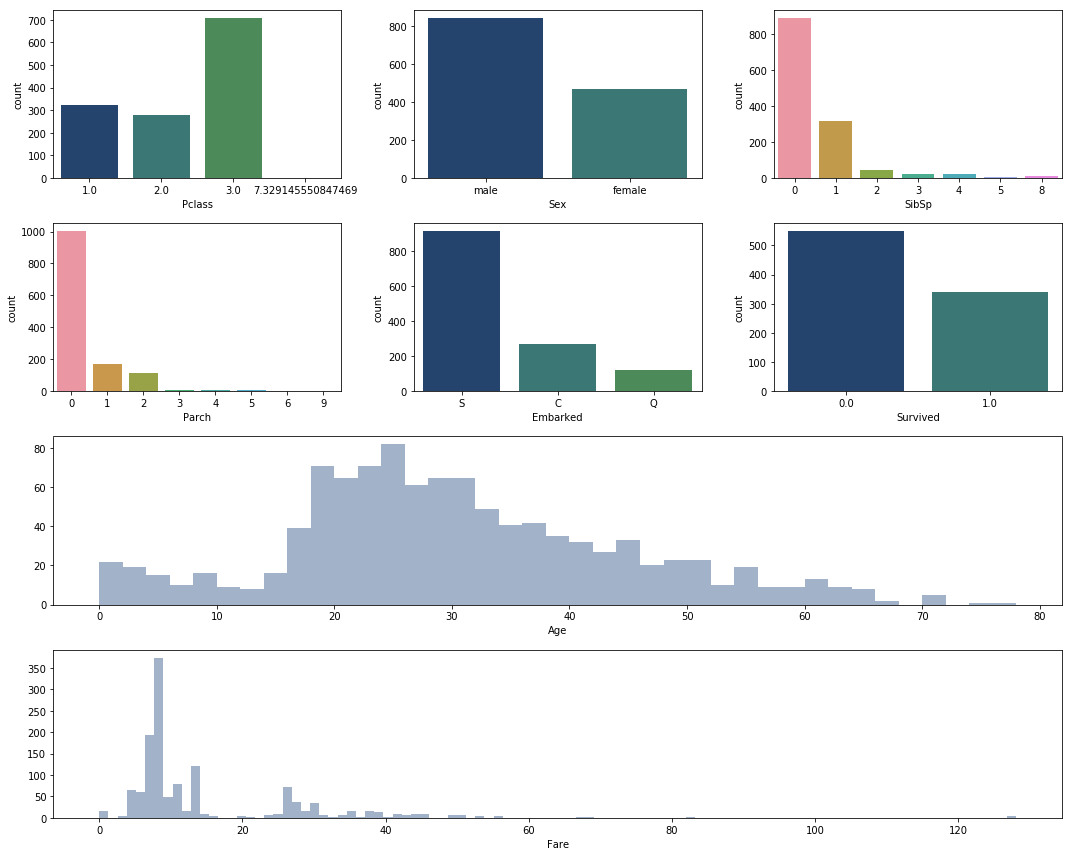

In [20]:
# EDA - Distributions
var_to_plot = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Survived']

# Plot Categorical Var
fig, axs = plt.subplots(4, 3, figsize=(15, 12))
for i, key in enumerate(var_to_plot):
    sns.countplot(key, data=full, ax=axs[i//3, i%3])

# Plot Age
plt.subplot2grid((4,3), (2,0), rowspan=1, colspan=3)
sns.distplot(full.Age.dropna(), bins=range(0, 80, 2), kde=False)
# binは要するに、イテレータで与えてるから始点と終点と刻みが指定できるんだろうなあ
plt.xlabel('Age')

# Plot Fare
# subplot2gridの第一引数：画面を何行何列に分割するのか
# rowspan=1、colspan=3などとすると、領域にまたがってかけるんだろうね。
# 分割した領域のうち、どこにグラフを書くのか
plt.subplot2grid((4,3), (3,0), rowspan=1, colspan=3)
sns.distplot(full.Fare.dropna(), bins=100, kde=False)
plt.xlabel('Fare')
plt.tight_layout()

EDA Relationships between features and survival

ValueError: left cannot be >= right

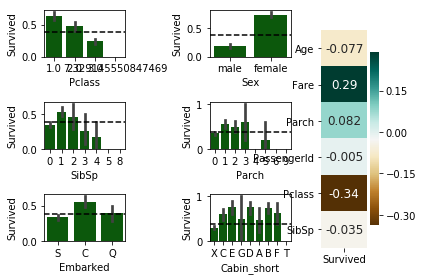

In [22]:
# Plot all categorical features with Survival rate
var_to_plot = ['Pclass', 'Sex', 'SibSp', 'Parch',
               'Embarked', 'Cabin_short']

f, axs = plt.subplots(3,5, sharey=True)
coord = [(0,0), (0,2),(1,0),(1,2),(2,0),(2,2)]
for i, key in enumerate(var_to_plot):
    plt.subplot2grid((3,5),(coord[i]),rowspan=1,colspan=2)
    sns.barplot(data=full,x=key,y='Survived',color='darkgreen')
    plt.axhline(y=0.3838, color='k',linestyle='--')

# Plot Correlation
corr = pd.DataFrame(full.corr()['Survived'][:-1])
plt.subplot2grid((3,5),(0,4),rowspan=3,colspan=1)
sns.heatmap(corr, cmap="BrBG",annot=True,annot_kws={'fontsize':12})
plt.tight_layout()
                     

Fiding from above glaph
１：SexはSurviveに大きく関係している(理由は、女子供が優先的にライフボートに乗せられるからだろうなあ)
２：Pclassが小さいほど生存しやすいことがわかった。単純にライフボートに近い場所に部屋があったため。
３：ヒートマップを見ると、AgeとSurvivedに相関はない
４：Cabinはなんかありそうだけどよーわからん
５：EmbarkはCに行ったら生き残りやすくて、Sだとダメなことがわかる

In [67]:
# Create DataFrame Features to record potential predictors for later model training
# SexとPclassとFareが良さそうなので、そいつらを使う
features = pd.DataFrame()
features['Pclass'] = full['Pclass']
features['Fare'] = full['Fare']
features['Sex'] = full['Sex']

In [ ]:
# Ticketの種類がパースした後でも多すぎるので、傾向を見る。
# 10個以上あるものについてのみ
d = dict(full['Ticket_short'].value_counts())
ticket_count = full['Ticket_short'].map(d)
display(full.groupby('Ticket_short')
        .Survived.aggregate(['mean', 'count'])
        .dropna().sort_values('count').transpose())
         